# Training / Test Data



> Predictive power is assessed using metrics computedfrom a holdout set or using cross-validation (Stone,1974; Geisser,1975)

> Testing the procedure on the data that gave it birth is almost certain to overestimate performance” (Mosteller and Tukey,1977).

https://www.stat.berkeley.edu/~aldous/157/Papers/shmueli.pdf

Let’s extend this idea of training and test splits. Remember, our goal is to generate a robust model that better estimates out-of-sample error. We can do this by resampling our data set in a way that allows us to learn from the data but not so much so that it follows the data set too closely.

We can take a single data set and partition / split it into a number of train / test subsets. We just did that in the earlier section but we only did it once. If we do this a number of times we hope we are training our model more effectively.

What would the RMSE look like if we created say K number of subsets of the data frame and selectively held out each of the K subsets, built a model on the combined remaining subsets, and then tested the model on the holdout ? We would then average the RMSE to get an idea of its variation. The series of sequential steps would be as follows:

```  
  Subset the data frame into k groups 
  For each subset:
     Consider the subset as a "hold out"" or test data set
     Combine the remaining subsets as a training data set
     Fit a model on the combined training set 
     Evaluate the model using the holdout test set
     Save the evaluation score (e.g. RNSE)

  Summarize evaluation score (e.g. mean, MSE, RMSE, etc)
```

This is called K-Fold Cross Validation. A general view of this procedure is depicted in the following figure which shows a 5 Fold scenario.

<img src="pics/folds_cv_latex.png" width ="700" height=700>


Now, here is the general idea in illustrated form relative to mtcars. Assume we want 4 folds. We would divide the data frame into 4 folds of 8 records each. The first model would be built using Fold 1 as the holdout / test data set after first combining Folds 2,3 and 4 into a training set.

<img src="pics/cv1.png" width ="700" height=700>

So the second iteration would then take the second fold as the holdout / test data frame and combine Folds 1,3, and 4 into a training data frame.

<img src="pics/cv2.png" width ="700" height=700>


So we can do something like this by first splitting a data frame into K groups. 

In [1]:
import pandas as pd
# Read in some data
url = "https://raw.githubusercontent.com/steviep42/bios534_spring_2020/master/data/mtcars.csv"

# Setup some helpful tools
import pandas as pd
mtcars = pd.read_csv(url)

# Split a DF into groups of (hopefully) equal sizes   
group_size = 8
folds = [mtcars.iloc[i:i+group_size] for i in range(0,len(mtcars)-group_size+1,group_size)]

Check out the folds to get a better understanding of what is going on. We generated a list that has 8 elements each of which holds a 4 element vector corresponding to indices for records in the mtcars data frame.

In [2]:
[print("\n Fold number: %d \n \n" % (i+1) ,folds[i]) for i in range(0,len(folds))]


 Fold number: 1 
 
     mpg  cyl   disp   hp  drat     wt   qsec  vs  am  gear  carb
0  21.0    6  160.0  110  3.90  2.620  16.46   0   1     4     4
1  21.0    6  160.0  110  3.90  2.875  17.02   0   1     4     4
2  22.8    4  108.0   93  3.85  2.320  18.61   1   1     4     1
3  21.4    6  258.0  110  3.08  3.215  19.44   1   0     3     1
4  18.7    8  360.0  175  3.15  3.440  17.02   0   0     3     2
5  18.1    6  225.0  105  2.76  3.460  20.22   1   0     3     1
6  14.3    8  360.0  245  3.21  3.570  15.84   0   0     3     4
7  24.4    4  146.7   62  3.69  3.190  20.00   1   0     4     2

 Fold number: 2 
 
      mpg  cyl   disp   hp  drat     wt   qsec  vs  am  gear  carb
8   22.8    4  140.8   95  3.92  3.150  22.90   1   0     4     2
9   19.2    6  167.6  123  3.92  3.440  18.30   1   0     4     4
10  17.8    6  167.6  123  3.92  3.440  18.90   1   0     4     4
11  16.4    8  275.8  180  3.07  4.070  17.40   0   0     3     3
12  17.3    8  275.8  180  3.07  3.730  17.

[None, None, None, None]

Next, we could then loop through each of these "folds" and train a model on all BUT that fold while later treating that fold as the testing data set. As before, we'll define our own RMSE function which is the performance metric we are currently focusing upon. Later on, you will see that defining our own function is unnecessary. 

Note that if we wanted, we could reshuffle or scramble the data frame before we split it. At this point, it is not necessary but later on it will be helpful

In [3]:
print(mtcars.sample(len(mtcars))[0:5])
print()

# This time we get a different order
print(mtcars.sample(len(mtcars))[0:5])

     mpg  cyl   disp   hp  drat     wt   qsec  vs  am  gear  carb
17  32.4    4   78.7   66  4.08  2.200  19.47   1   1     4     1
2   22.8    4  108.0   93  3.85  2.320  18.61   1   1     4     1
24  19.2    8  400.0  175  3.08  3.845  17.05   0   0     3     2
19  33.9    4   71.1   65  4.22  1.835  19.90   1   1     4     1
28  15.8    8  351.0  264  4.22  3.170  14.50   0   1     5     4

     mpg  cyl   disp   hp  drat     wt   qsec  vs  am  gear  carb
17  32.4    4   78.7   66  4.08  2.200  19.47   1   1     4     1
31  21.4    4  121.0  109  4.11  2.780  18.60   1   1     4     2
0   21.0    6  160.0  110  3.90  2.620  16.46   0   1     4     4
14  10.4    8  472.0  205  2.93  5.250  17.98   0   0     3     4
19  33.9    4   71.1   65  4.22  1.835  19.90   1   1     4     1


In [4]:
# Let's define our RMSE function - soon you will see that this is unnecessary

def rmse(actual,predictions):
   from math import sqrt
   myrmse = sqrt(((predictions-actual)**2).mean())
   return round(myrmse,3)


<AxesSubplot:>

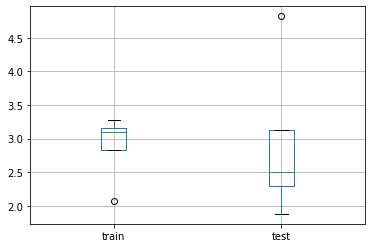

In [5]:
import statsmodels.api as sm 

# Setup a Blank List
rmse_list = []

# Create a series of training and test data sets
for ii in range(0,len(folds)):
    test = folds[0]
    train = pd.concat(folds[1:len(folds)])
    folds.append(folds[0])
    del folds[0]
 
    # Call the OLS function
    
    # Fit
    result = sm.OLS(train.mpg,sm.add_constant(train.wt)).fit()
    
    # Capture training and testing error
    train_rmse = rmse(train.mpg,result.predict(sm.add_constant(train.wt)))
    test_rmse  = rmse(test.mpg,result.predict(sm.add_constant(test.wt)))
    
    # Append the errors to the list
    rmse_list.append([train_rmse,test_rmse])

# Boxplot the resulting training and testing errors
error_frame = pd.DataFrame(rmse_list,columns=['train','test'])

error_frame.describe()
error_frame.boxplot()

The above list structure allow us to drill down into any aspect of the models and predictions we have made for each of the folds. More importantly we can see how well the model works against each of the individual holdout / test data sets. In the end, we just want to be able to look at the average RMSE across the folds. This gives us clues as to how good the model might perform against new data.

<AxesSubplot:title={'center':'Training and Testing Error'}>

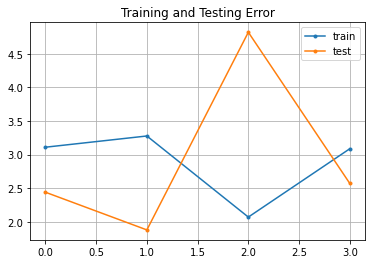

In [6]:
error_frame.plot(kind="line",title="Training and Testing Error", style='.-',grid=True)

## Create A Function To Automate Things

Since we have gone to the trouble of creating a loop structure to process the folds, we could easily turn this into a function to automate the splitting of the data frame across some arbitrary number of folds just to get an idea of how the RMSE looks for different numbers of folds.

We could even have our function accommodate different formula if we wanted but we won’t focus on that right now. You will soon discover that the scikit-learn package does these kinds of things for you but we aren’t quite there yet.

In [7]:
def cross_validator(group_size=4,scramble=1,df=mtcars): 

    # If scramble is 1 then we resample the data frame
    if (scramble == 1):
        tempdf = df.sample(len(df))
    
    # Split the data frame intro groups the size of "group_size"
    lst = [tempdf.iloc[i:i+group_size] for i in range(0,len(tempdf)-group_size+1,group_size)]
    
    # Setup a list to capture the rmse for training and testing
    rmse_list = []

    # Loop through the split dataframe
    for ii in range(0,len(lst)):
        test = lst[0]
        train = pd.concat(lst[1:len(lst)])
        lst.append(lst[0])
        del lst[0]

        # Do regression and figure out rmse for training and test
        result = sm.OLS(train.mpg,sm.add_constant(train.wt)).fit()
        train_rmse = rmse(train.mpg,result.predict(sm.add_constant(train.wt)))
        test_rmse  = rmse(test.mpg,result.predict(sm.add_constant(test.wt)))
          
        # append the data into the list 
        rmse_list.append([train_rmse,test_rmse])
        
        title = "RMSE for " + str(round(len(df)/group_size,2)) + " folds"
        
    return([title,pd.DataFrame(rmse_list,columns=['train','test'])])


<AxesSubplot:title={'center':'RMSE for 8.0 folds'}>

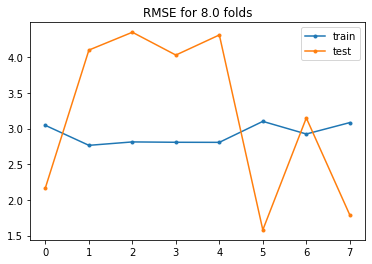

In [8]:
# Now Call the function
title, error_frame = cross_validator(4,1)

# Make a Plot of the Error
error_frame.plot(kind='line',title = title, style='.-')

## Repeated Cross Validation

Since we already have an existing function we can up the ante by repeating the cross validation. This will provide more data on how the RMSE might be distributed across multiple runs, each of which does Cross Fold validation. This example will repeat a 4 Fold Cross Validation , 20 times. In the domain of Machine Learning this is known as "Repeated Cross Fold Validation". We can reuse our function from before and add a new argument to it and make a minor adjustment to the coding logic to accomodate this new capability.


In [9]:
def cross_validator(group_size=4,scramble=1,df=mtcars,repeat=10): 

    # Setup a list to capture the rmse for training and testing
    rmse_list = []

    for jj in range(0,repeat):
        if (scramble == 1):
            tempdf = df.sample(len(df))

        # Split the data frame intro groups the size of "group_size"
        lst = [tempdf.iloc[i:i+group_size] for i in range(0,len(tempdf)-group_size+1,group_size)]

        # Loop through the split dataframe
        for ii in range(0,len(lst)):
            test = lst[0]
            train = pd.concat(lst[1:len(lst)])
            lst.append(lst[0])
            del lst[0]

            # Do regression and figure out rmse for training and test
            result = sm.OLS(train.mpg,sm.add_constant(train.wt)).fit()
            train_rmse = rmse(train.mpg,result.predict(sm.add_constant(train.wt)))
            test_rmse  = rmse(test.mpg,result.predict(sm.add_constant(test.wt)))

            # append the data into the list 
            rmse_list.append([train_rmse,test_rmse,jj+1])

            title = "RMSE for " + str(round(len(df)/group_size,2)) + " folds and " + str(repeat) + " repeats"

    return([title,pd.DataFrame(rmse_list,columns=['train','test','repeat'])])


<AxesSubplot:title={'center':'RMSE for 4.0 folds and 10 repeats'}>

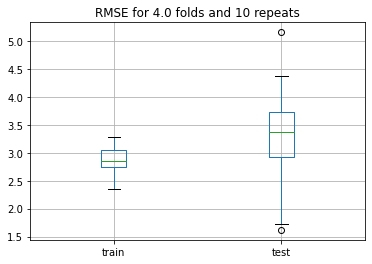

In [10]:
title, error_frame = cross_validator(group_size=8,repeat=10)
error_frame[['train','test']].plot(kind="box",grid=True, title=title)

<AxesSubplot:title={'center':'test'}, xlabel='repeat'>

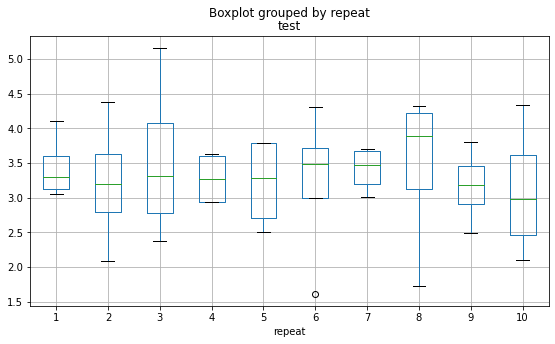

In [11]:
# This shows the test RMSE for each repeat
error_frame.boxplot(column=['test'],by="repeat",figsize=(9,5)) 

## Bootstrap

An alternative to K-Fold Cross Validation is to use the bootstrap sampling approach which will produce training data sets the same size as the original data set although some observations might be repeated as the sampling process is done with replacement. The observations that do not appear in each of the training sets are then used as a test set. These observations are known as “out of bag samples”. We’ll can alter our existing function to accomodate this form of sampling. But before we do that let me show you what I mean.

In [12]:
 mtcars.sample(len(mtcars),replace=True,random_state=100)

,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
8,22.8,4,140.8,95,3.92,3.150,22.90,1,0,4,2
24,19.2,8,400.0,175,3.08,3.845,17.05,0,0,3,2
3,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
7,24.4,4,146.7,62,3.69,3.190,20.00,1,0,4,2
23,13.3,8,350.0,245,3.73,3.840,15.41,0,0,3,4
15,10.4,8,460.0,215,3.00,5.424,17.82,0,0,3,4
16,14.7,8,440.0,230,3.23,5.345,17.42,0,0,3,4
10,17.8,6,167.6,123,3.92,3.440,18.90,1,0,4,4
30,15.0,8,301.0,335,3.54,3.570,14.60,0,1,5,8
20,21.5,4,120.1,97,3.70,2.465,20.01,1,0,3,1


Here is an easier way to see what gets duplicated as part of this process

In [13]:
temp = mtcars.sample(len(mtcars),replace=True,random_state=100)
temp["is_duplicate"] = temp.duplicated()
temp[temp.is_duplicate]

,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb,is_duplicate
2,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1,True
2,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1,True
2,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1,True
16,14.7,8,440.0,230,3.23,5.345,17.42,0,0,3,4,True
24,19.2,8,400.0,175,3.08,3.845,17.05,0,0,3,2,True
15,10.4,8,460.0,215,3.00,5.424,17.82,0,0,3,4,True
16,14.7,8,440.0,230,3.23,5.345,17.42,0,0,3,4,True
2,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1,True
27,30.4,4,95.1,113,3.77,1.513,16.90,1,1,5,2,True


In [14]:
temp.groupby('is_duplicate').size()

is_duplicate
False    23
True      9
dtype: int64

So keep in mind that all we are doing is changing ONLY the way in which we sample the data. We are still doing the cross fold validation. Chaning the function is easy to do.

In [15]:
def cross_validator(group_size=4,df=mtcars,repeat=1,boot=True): 

    # Setup a list to capture the rmse for training and testing
    rmse_list = []

    for jj in range(0,repeat):
        
        # If boot 
        if (boot):
            tempdf = df.sample(len(df),replace=True)
        else:
            tempdf = df.sample(len(df),replace=False)

        # Split the data frame intro groups the size of "group_size"
        lst = [tempdf.iloc[i:i+group_size] for i in range(0,len(tempdf)-group_size+1,group_size)]

        # Loop through the split dataframe
        for ii in range(0,len(lst)):
            test = lst[0]
            train = pd.concat(lst[1:len(lst)])
            lst.append(lst[0])
            del lst[0]

            # Do regression and figure out rmse for training and test
            result = sm.OLS(train.mpg,sm.add_constant(train.wt)).fit()
            train_rmse = rmse(train.mpg,result.predict(sm.add_constant(train.wt)))
            test_rmse  = rmse(test.mpg,result.predict(sm.add_constant(test.wt)))

            # append the data into the list 
            rmse_list.append([train_rmse,test_rmse,jj+1])
            
            if (boot):
                title = "RMSE for " + str(round(len(df)/group_size,2)) + " folds and " + str(repeat) + " repeats - bootstrapped"
            else:
                title = "RMSE for " + str(round(len(df)/group_size,2)) + " folds and " + str(repeat) + " repeats"

    return([title,pd.DataFrame(rmse_list,columns=['train','test','repeat'])])


In [16]:
title, error_frame = cross_validator(group_size=4,repeat=10,boot=True)
error_frame

,train,test,repeat
0,3.058,2.422,1
1,2.850,4.090,1
2,3.045,2.653,1
3,2.776,4.187,1
4,3.133,1.548,1
...,...,...,...
75,2.434,2.509,10
76,2.447,2.243,10
77,2.358,2.845,10
78,2.411,2.498,10


In [17]:
error_frame[['train','test']].describe()

,train,test
count,80.000000,80.000000
mean,2.803987,2.928663
std,0.443484,1.045900
min,1.623000,0.739000
25%,2.507750,2.252750
50%,2.819000,2.735000
75%,3.050250,3.783500
max,3.840000,5.556000


Text(0.5, 1.0, 'RMSE for 8.0 folds and 10 repeats - bootstrapped')

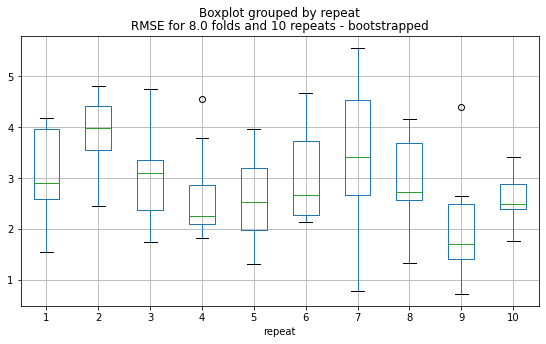

In [18]:
import matplotlib.pyplot as plt
error_frame.boxplot(column=['test'],by="repeat",figsize=(9,5)) 
plt.title(title)

If we wanted to look at the distribtuion of Test RMSE across all booststrapped repeats 

Text(0.5, 1.0, 'Test RMSE for 8.0 folds and 10 repeats - bootstrapped')

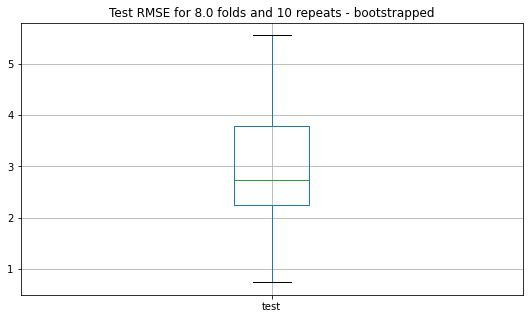

In [19]:
error_frame.boxplot(column=['test'],figsize=(9,5)) 
plt.title("Test " + title)

How does this compare to a non-bootstrapped cross fold vslidation ?

In [20]:
title, error_frame = cross_validator(group_size=4,repeat=10,boot=False)
error_frame

,train,test,repeat
0,3.020,2.399,1
1,3.143,0.716,1
2,2.880,3.510,1
3,2.728,4.886,1
4,3.003,2.544,1
...,...,...,...
75,2.970,2.992,10
76,2.991,2.678,10
77,2.964,2.984,10
78,2.598,4.858,10


Text(0.5, 1.0, 'Test RMSE for 8.0 folds and 10 repeats')

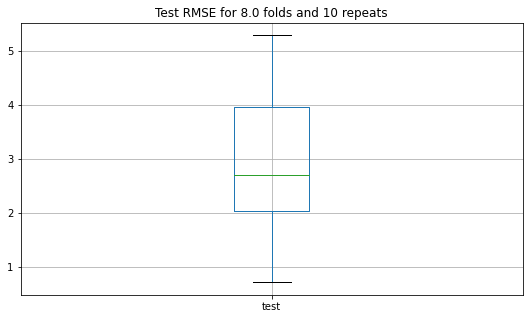

In [21]:
error_frame.boxplot(column=['test'],figsize=(9,5)) 
plt.title("Test " + title)